# Transformador

La arquitectura original de un transformador es una arquitectura encoder-decoder, cuenta con dos grandes secciones en donde la primera, el encoder, toma la cadena de entrada y la codifica a través de un mecanismo de auto-atención para pasar los datos codificados a un decoder, la segunda sección del transformador, que se encargará de decodificar estos datos en una nueva cadena. Como puede imaginarse, los transformadores son de gran utilidad para la traducción automática y otras tareas que pasan de secuencia a secuencia. 

Los transformadores han tenido un gran impacto en el procesamiento del lenguaje natural, pues permiten obtener modelos de gran capacidad que, además, son capaces de generar lenguaje de manera efectiva. Para poder definir la arquitectura del transformador definimos el encoder y el decoder; para este último requerimos de un mecanismo de atención que tome tanto la cadena de entrada como la cadena de salida.


## Atención encoder-decoder

Al igual que los modelos de atención en las redes recurrentes encoder-decoder, los transformadores utilizan una atención que representa los elementos de la salida a partir de los datos de entrada, para poner atención a aquellos elementos de entrada que tengan más influencia en la salida actual. En este caso, se toma una query que es elemento de la salida. Supongamos que tenemos una cadena de entrada $x_1, x_2, \cdots x_n$ que se mapea en una cadena de salida $y_1, y_2, \cdots y_m$, entonces buscaremos obtener una representación de los elementos de salida $y_1, y_2, \cdots y_m$ en términos de la entrada $x_1, x_2, \cdots x_n$. Esta representación pondrá "atención" a los elementos de entrada:

$$h^y_i = \sum_{j=1}^n \alpha(y_i, x_j) \psi_v(x_j)$$ 

Se obtendrán las representaciones para los $m$ elementos de salida. Aquí cabe decr que $\psi_v(x_j) = W_v x_j$ es una proyección en el espacio de valores de los datos de entrada y los pesos de atención se estiman de manera similar, peroconsiderando que los elementos $x_j$ corresponden a las entradas y $y_i$ a las salidas. De tal forma que estos pesos de atención se estiman como:

$$\alpha(y_i, x_j) = Softmax_x\Big( \frac{\psi_q(y_i)^T  \psi_k(x_j)}{\sqrt{d}} \Big)$$

La función $\psi_q(y_i) = W_q y_i$ es una proyección al espacio de queries de los valores de las salidas, mientras que $\psi_k(x_j) = W_k x_j$ es la proyección al espacio de keys de las codificaciones de entrada. De tal forma que la matriz de pesos de atención muestra las relaciones entre la entrada y la salida:

<img src="images/EncDecAtt.png" width="500" class="center">

La atención entre el encoder y el decoder es similar a la auto-atención que se usa en cada módulo, pero toma como valores de entrada $x_1, x_2, \cdots, x_n$ a las salidas del decoder, que ya han sido representados por medio de la auto-atención. Asimismo, toma los tókens de salida que tmabién representa por medio de auto-atención (enmascarada). En la implementación de esta atención llamamos <tt>encode</tt> a los elementos codificados del encoder.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import copy
from tqdm import tqdm
from transformers import *

class Attention(nn.Module):
    def __init__(self, d_model):
        super(Attention, self).__init__()
        # Capas de proyecciones
        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model, bias=False)
        self.K  = nn.Linear(d_model, d_model, bias=False)
        self.V  = nn.Linear(d_model, d_model, bias=False)
        
    def forward(self, x, encode):
        # Proyección de los datos
        query,key,value = self.Q(x),self.K(encode),self.V(encode)
        scores = torch.matmul(query, key.T)/np.sqrt(self.d_model)
        p_attn = torch.nn.functional.softmax(scores, dim = -1)
        Vs = torch.matmul(p_attn, value).reshape(x.shape)
        
        return Vs, p_attn

## Encoder

El encoder codifica la cadena de entrada en un conjunto de vectores con que se alimentará el decoder para obtener las salidas. Para hacer esta codificación, la arquitectura que se toma cuenta con: 1) embeddings y codificación posicional; 2) auto-atención multi-cabeza; y 3) capa feedforward. Además aplica sum ay normalización en cada capa. La siguiente figura expresa esta estructura:

<img src="images/encoder.png" width="300" class="center">

En el diagrama las conexiones que saltan capas representan la suma y normalización. Definimos la implementación del encoder de manera similar que lo hemos hecho en la definición de las <a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/html/06AttentionHead.html">cabezas de auto-atención</a>.

In [2]:
class Encoder(nn.Module):
    def __init__(self, in_size, d_model, hidden=128, heads=3, dropout=0.3):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.enc = Encoding(in_size, d_model)
        self.att = nn.ModuleList([copy.deepcopy(SelfAttention(d_model)) for _ in range(heads)])
        self.lin = nn.Linear(heads*d_model, d_model, bias=True)
        self.norm = LayerNorm(d_model)
        self.ffw = nn.Sequential(nn.Linear(d_model, hidden), nn.ReLU(),
                                nn.Linear(hidden, d_model))
        self.drop1 = nn.Dropout(p=dropout)
        self.drop2 = nn.Dropout(p=dropout)
        self.drop3 = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x_e = self.enc(x)
        x_e = self.drop1(x_e)
        head_att = [head(x_e) for head in self.att]
        self.att_weights = [head[1] for head in head_att]
        heads = [head[0] for head in head_att]
        multi_heads = torch.cat(heads, dim=-1)
        h = self.lin(multi_heads)
        h_norm = x_e + self.norm(h)
        h_norm = self.drop2(h_norm)
        out = self.ffw(h)
        
        return self.drop3(h_norm + self.norm(out))

## Decoder

El decoder es particular; suarquitectura es más compleja pero también guarda similitudes con la del encoder, pues la cadena de salida pasa por las siguientes capas: 1) embedding y codificación posicional; 2) auto-atención enmascarada; y 3) capa feedforward, además de la suma y normalización. En primer lugar, la auto-atención que se utiliza es enmascarada, pues se puede ver que en la etapa de inferencia, cuando predecimos cadenas que no han sido vistas previamente, se busca generar una nueva cadena a partir de predecir la palabra siguiente. Por tanto, aquí es necesario enmascarar los tókens subsiguientes en la cadena.

Durante el entrenamiento, contamos con los pares $(\mathbf{x}, \mathbf{y})$ donde conocemos la cadena de salida. Por tanto, podemos aplicar las primeras tres capas de forma similar a como se ha mostrado en la sección de <a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/html/07MaskedAttention.html">auto-atención enmascarada</a>. En este caso, no habrá problema en la predicción. Sin embargo en la inferencia requeriremos otra estrategia para generar los tókens de salida. 

El decoder, además de estas capas, incorporará una capa de atención (generalmente también multi-cabeza) como la que hemos descrito arriba, donde tomará las codificaciones de la entrada y las utilizará para crear las representaciones de la salida a partir del mecanismo de atención. El siguiente diagrama muestra la estructura del decoder:

<img src="images/Decoder.png" width="300" class="center">

Cabe señalar que la capa de auto-atención no sólo toma la salida de la capa previa de auto-atención enmascarada, la que conforma el query, sino que toma la salida del encoder para conformar key y value. En este caso, debemos enviar al decoder los elemntos del decoder para que pueda trabajarlos. 

In [3]:
class Decoder(nn.Module):
    def __init__(self, in_size, d_model, hidden=128, heads=3, dropout=0.3):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.enc = Encoding(in_size, d_model)
        self.self_att = nn.ModuleList([copy.deepcopy(MaskAttention(d_model)) for _ in range(heads)])
        self.att = Attention(d_model)
        self.lin = nn.Linear(heads*d_model, d_model, bias=True)
        self.norm = LayerNorm(d_model)
        self.ffw1 = nn.Sequential(nn.Linear(d_model, hidden), nn.ReLU(),
                                nn.Linear(hidden, d_model))
        self.ffw2 = nn.Sequential(nn.Linear(d_model, hidden), nn.ReLU(),
                                nn.Linear(hidden, d_model))
        self.drop1 = nn.Dropout(p=dropout)
        self.drop2 = nn.Dropout(p=dropout)
        self.drop3 = nn.Dropout(p=dropout)
    
    def forward(self, x, encode):
        x_e = self.enc(x)
        x_e = self.drop1(x_e)
        head_att = [head(x_e) for head in self.self_att]
        self.att_weights = [head[1] for head in head_att]
        heads = [head[0] for head in head_att]
        multi_heads = torch.cat(heads, dim=-1)
        h = self.lin(multi_heads)
        h_norm = x_e + self.norm(h)
        h_norm = self.ffw1(h_norm)
        h_norm = h + self.norm(h_norm)
        h_norm = self.drop2(h_norm)
        enc_dec, self.enc_dec_att = self.att(h_norm, encode)
        enc_dec = h_norm + self.norm(enc_dec)
        out = self.ffw2(enc_dec)
        
        return self.drop3(h_norm + self.norm(out))

## Encoder-decoder

Ya que hemos definido de manera separada el encoder y el decoder, la arquitectura final incorporará ambos conectando la salida del encoder con la atención en el decoder que, además, toma la salida de la representación como query. El resultado de esta última aplicación de la atención entre los elementos del encoder y del decoder pasará por una capa feedforward (además de la suma y normalización) para obtener las representaciones finales. Finalmente, para obtener las probabilidades de salida para las predicciones aplicamos una capa lineal y una activación con la función Softmax. De esta forma, obtendremos probabilidades de una cadena de salida con la que podremos hacer predicciones. El siguiente diagrama expresa la arquitectura del transformer.

<img src="images/Transformer.png" width="460" class="center">

Cabe señalar que originalmente Vaswani et al. (2017) proponen que se creen copias tanto del encoder, como del decoder. En este cado, no aplicamos estas copias, sólo utilizamos un encoder y un decoder. Asimismo, no hemos declarado multi-cabezas en la atención entre el encoder y el decoder, esto con motivos de simplificar la implementación. En esta implementación ademas definimos funciones de encode y decode que utilizaremos para la inferencia.

In [4]:
class EncoderDecoder(nn.Module):
    def __init__(self, in_size, out_size, d_model, hidden=128, heads=5, dropout=0.3):
        super(EncoderDecoder, self).__init__()
        self.d_model = d_model
        self.encoder = Encoder(in_size, d_model, hidden=hidden, heads=heads, dropout=dropout)
        self.decoder = Decoder(out_size, d_model, hidden=hidden, heads=heads, dropout=dropout)
        self.generator = nn.Sequential(nn.Linear(d_model, out_size), nn.Softmax(1))
        
    def forward(self, x, y):
        enc = self.encode(x)
        out = self.decode(y, enc)
        
        return out

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x, encode):
        return self.generator(self.decoder(x, encode))

## Aplicaicón del transformador

Para ejemplificar el uso del transformador definimos un problema de traducción del español al otomí. Utilizamos un corpus paralelo que obtenemos a partir de la paquetería de <a href="https://pypi.org/project/elotl/">Elotl</a>. En este caso, generamos un vocabulario para el lenguaje fuente y el lenguaje objetivo, y asignamos índices a cada tóken/palabra para poder indexar estas palabras en las cadenas que se van a traducir.

In [5]:
import elotl.corpus
import matplotlib.pyplot as plt
from seaborn import heatmap as hm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

corpus_ot = elotl.corpus.load('tsunkua')
src, tgt = zip(*[(sents[0].lower().split(), sents[1].lower().split()) for sents in corpus_ot])

bos = 0
eos = 1
src_voc = vocab()
tgt_voc = vocab()
src_voc['bos'], tgt_voc['bos'] = bos, bos
src_voc['eos'], tgt_voc['eos'] = eos, eos

src_sents = list(index(src, src_voc))
tgt_sents = list(index(tgt, tgt_voc))
x = [torch.cat((torch.tensor([src_voc['[bos]']]),s, torch.tensor([src_voc['[eos]']])), axis=0).to(device) for s in src_sents]
y = [torch.cat((torch.tensor([tgt_voc['[bos]']]),s, torch.tensor([tgt_voc['[eos]']])), axis=0).to(device) for s in tgt_sents]

#print(src_voc, tgt_voc)

Ahora generamos el modelo especificando el tamaño de vocabulario de entrada y el de salida. Definimos la dimensión del modelo y podemos considerar otros hiperparámetros si es necesario.

In [6]:
len_src = len(src_voc)
len_tgt = len(tgt_voc)
model = EncoderDecoder(in_size=len_src, out_size=len_tgt, d_model=128, hidden=256).to(device)

#Carga del mo"delo
model.load_state_dict(torch.load('transformer.model', map_location=torch.device('cpu')))
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (enc): Encoding(
      (emb): Embedding(4044, 128)
      (pe): PositionalEncoding()
    )
    (att): ModuleList(
      (0-4): 5 x SelfAttention(
        (Q): Linear(in_features=128, out_features=128, bias=False)
        (K): Linear(in_features=128, out_features=128, bias=False)
        (V): Linear(in_features=128, out_features=128, bias=False)
      )
    )
    (lin): Linear(in_features=640, out_features=128, bias=True)
    (norm): LayerNorm()
    (ffw): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
    )
    (drop1): Dropout(p=0.3, inplace=False)
    (drop2): Dropout(p=0.3, inplace=False)
    (drop3): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (enc): Encoding(
      (emb): Embedding(3599, 128)
      (pe): PositionalEncoding()
    )
    (self_att): ModuleList(
      (0-4): 5 x MaskAttention(
        (Q): Linear(in_fea

### Entrenamiento

Para el entrenamiento utilizamos lotes de tamaño 1, es decir, pasamos ejemplo por ejemplo, pero es posible crear lotes de mayor tamaño. Como función objetivo utilizamos la entropía cruzada, pues nuestra función de salida es la función Softmax que obtiene probabilidades. El optizador es el <a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/html/08Noam.html">optimizador Noam</a> y entrenamos de forma común por un número $T$ de iteraciones. 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = NoamOptimizer(model.parameters(), model.d_model, decay=0)
epochs = range(100)

#Entrenamiento
model.train()
for t in tqdm(epochs):
    for i in torch.randperm(len(x)):
        prediction = model(x[i], y[i])
        optimizer.zero_grad()
        loss_value = criterion(prediction, y[i])
        loss_value.backward()
        optimizer.step()
        
#torch.save(model.state_dict(), 'transformer.model')

### Inferencia

Para realizar la predicción de nuevas cadenas a partir de datos novedosos de traducción, definimos un decodificador ambicioso, que es un simple decodificador que en cada tiempo tomar el tóken con la probabilidad más alta como el tóken siguiente. Este tóken se incorpora a la cadena predica para volver a estimar otra palabra aplicando el decoder. Como se puede ver en el código, el encoder se aplica una sola vez (utilizamos la función <tt>encode</tt>), mientras que el decoder se aplica tantas veces como la longitud de la cadena de salida. En cada paso se incopora la palabra predicha anteriormente. Al inicio sólo tomamos el símbolo de inicio de palabra. De esta forma, se puede predecir una cadena de longitud arbtrario para la salida del transformador. Asimismo, definimos funciones auxiliares que nos permitirán pasar de las palabras en los lenguajes de entrada y salida a índices y viceversa.

In [7]:
model.eval()

def greedy_decode(model, x, max_len, start_symbol):
    encode = model.encode(x)
    ys = torch.ones(1).fill_(start_symbol).type_as(x.data)
    for i in range(max_len-1):
        prob = model.decode(ys, encode)
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word[-1].reshape(1)
        ys = torch.cat((ys, next_word), dim=0)
        
    return ys

tgt_voc_rev = {k:v for v,k in tgt_voc.items()}
def translate(sent, model, max_len=10):
    x_sents = []
    for w in sent.split():
        idx_w = src_voc[w]
        x_sents.append(idx_w)
    x_sents = [bos] + x_sents + [eos]
    y = greedy_decode(model, torch.tensor(x_sents).to(device), max_len, bos)
    sent = y.cpu().detach().tolist()
        
    return ' '.join([tgt_voc_rev[word] for word in sent][1:]) 

Finalmente, podemos obtener el resultado de traducción de un texto. Ya que sólo hemos definido una cabeza de atención entre el encoder y el decoder podemos visualizar cuáles son los pesos aprendidos. También se pueden visualizar los pesos de atención tanto en el encoder, como en el decoder (auto-atención enmascarada). 

Original: se calcina su piel
Traducción: xbi hñähñu. hokagihe nge'u̱


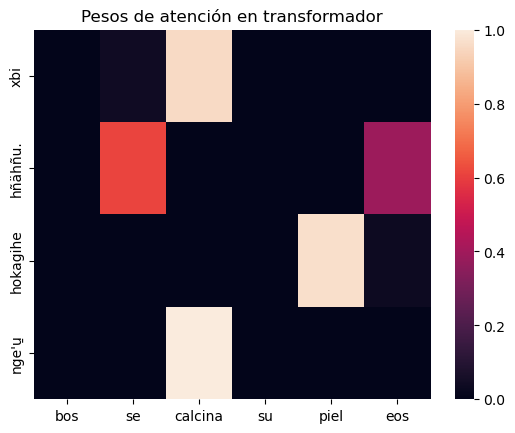

In [8]:
text = 'se calcina su piel'
result = translate(text, model, max_len=len(text.split())+1)
print('Original: {}\nTraducción: {}'.format(text,result))

hm(model.decoder.enc_dec_att.cpu().detach().numpy(), xticklabels=['bos']+text.split()+['eos'], 
   yticklabels=result.split(), vmin=0, vmax=1)
plt.title('Pesos de atención en transformador')
plt.show()

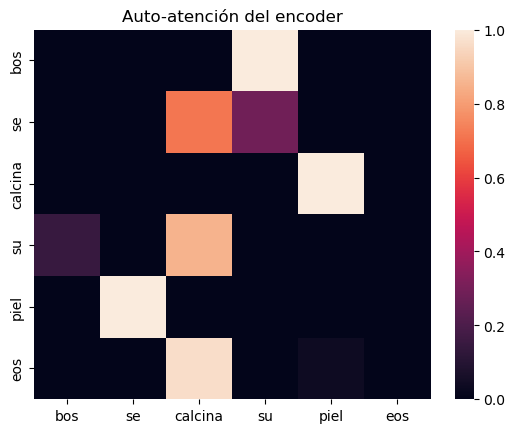

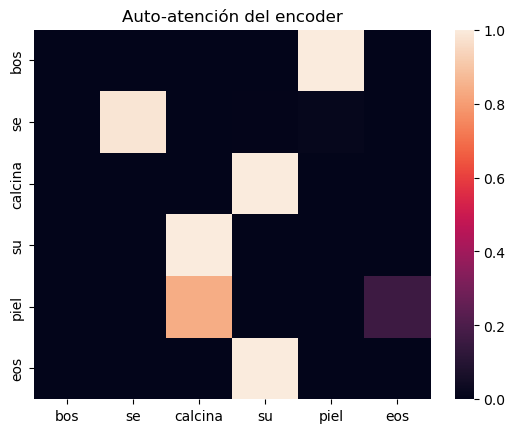

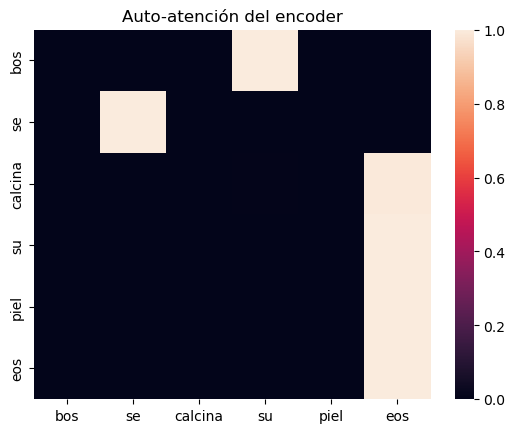

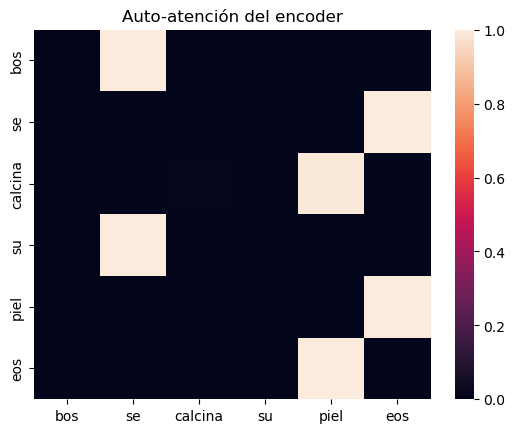

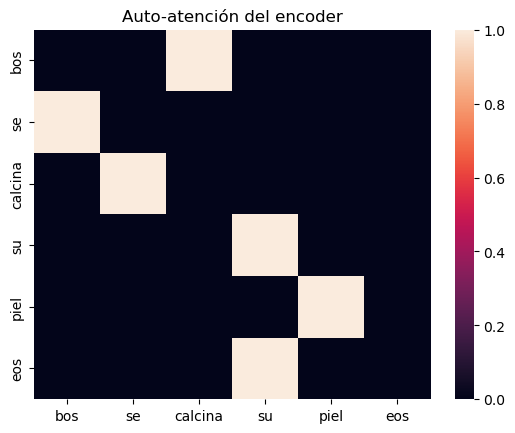

In [9]:
for i,att in enumerate(model.encoder.att_weights):
    hm(att.cpu().detach().numpy(), xticklabels=['bos']+text.split()+['eos'], 
       yticklabels=['bos']+text.split()+['eos'], vmin=0, vmax=1)
    plt.title('Auto-atención del encoder')
    plt.show()

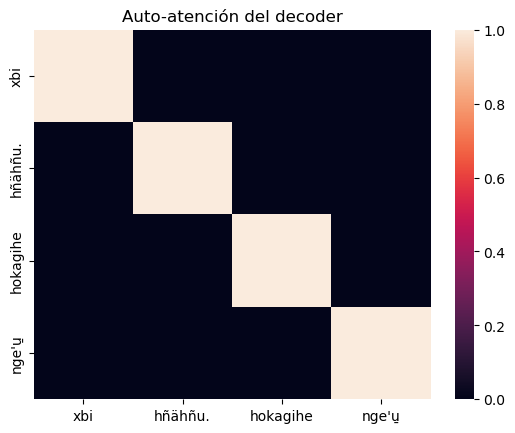

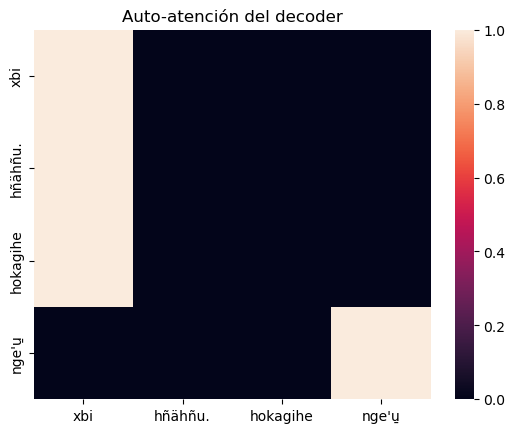

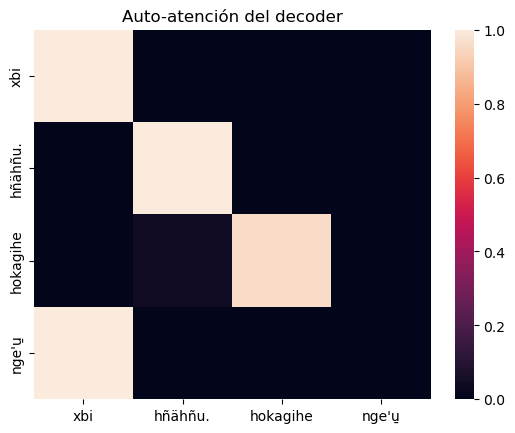

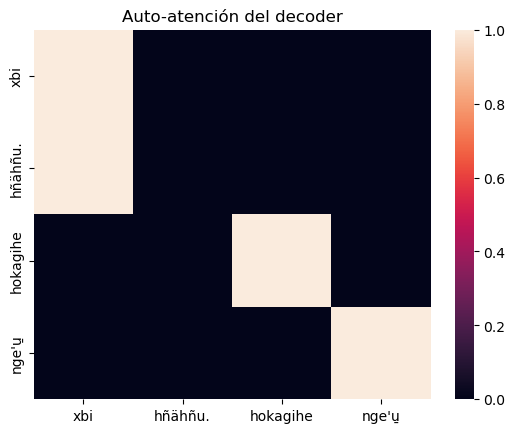

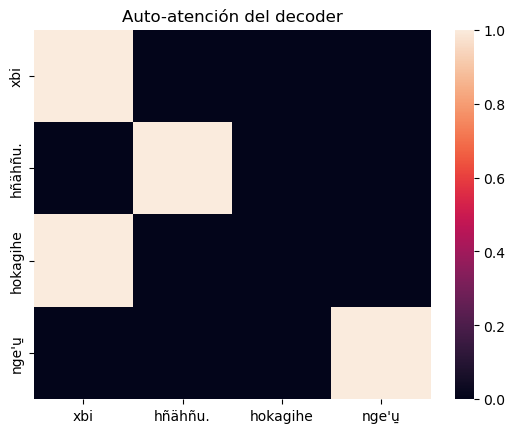

In [10]:
for i,att in enumerate(model.decoder.att_weights):
    hm(att.cpu().detach().numpy(), xticklabels=result.split(), 
       yticklabels=result.split(), vmin=0, vmax=1)
    plt.title('Auto-atención del decoder')
    plt.show()

## Referencias

<a href="https://nlp.seas.harvard.edu/2018/04/03/attention.html">The annotated transformer</a>

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). <it>Attention is all you need. Advances in neural information processing systems</it>, 30.

-----------------------------------------------------------------------

<a href="https://victormijangosdelacruz.github.io/MecanismosAtencion/">Principal</a>